# YouTube View Prediction - Part III 

## User Interface and Prediction

### Project Objective
This project demonstrates the implementation of a machine learning model that uses user inputs to predict the number of views for fitness videos.

In [9]:
# =====================================================================
# Import Libraries
# =====================================================================
import requests, sys, time, os, argparse
from datetime import date
from datetime import datetime
from pprint import pprint
import random
import numpy as np
import collections
import os.path
import numpy as np
import pandas as pd
import scipy
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from cryptography.fernet import Fernet
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from collections import Counter
from pprint import pprint
from wordcloud import WordCloud,STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import dill
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from IPython.display import HTML

In [24]:
# # =====================================================================
# # Button to hide/show codes
# # =====================================================================
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### 1. Import Data

In [4]:
# =====================================================================
# Import pre-generated data
# =====================================================================

# load feature data from a pickle file
import dill
import pickle

# with open('Data/fitness-feature-data.pkd', 'wb') as f:
#     dill.dump(fitness_features, f)

with open('Data/fitness-feature-data', 'rb') as f:
    fitness_features = dill.load(f)
    
# =====================================================================
# Split data for testing purpose
# =====================================================================
from sklearn.model_selection import train_test_split

X = fitness_features.drop('views', axis=1)
y = fitness_features.views

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Import Model

Data collection, preprocessing, and model training pipelines were developed in separate Jupyter notebooks, which can be found at https://github.com/jinerzhou/YouTube_Views_Prediction. Here, the most effective model will be imported and employed.


Multiple models were tested and assessed as part of the development of the present model architecture. These models comprised a numerical model with logistic regression, a bag-of-words text model, a TF-IDF text model, an aggregated model that combined numerical and text models, and a TensorFlow model that utilized MUSE tfhub embeddings. Next, further data engineering, model architecture, and feature engineering will be executed to identify the optimal performing model.

In [5]:
# =====================================================================
# Convert raw data to pandas dataframe
# =====================================================================
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        return pd.DataFrame(X)

# =====================================================================
# Change 2d array to 1d array
# =====================================================================
class FlattenArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):      
        return X.ravel()

# =====================================================================
# Model transformer
# =====================================================================
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model = model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        # Question: what should be returned?
        self.model.fit(X,y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.        
        return np.array(self.model.predict(X)).reshape(-1,1)

# =====================================================================
# Load pre-trained models
# =====================================================================
if __name__=='__main__':
    
    with open('Model/num_mdl', 'rb') as f:
        num_mdl = dill.load(f)
    with open('Model/cat_mdl', 'rb') as f:
        cat_mdl = dill.load(f)        
    with open('Model/full_mdl', 'rb') as f:
        full_mdl = dill.load(f)
        
    with open('Model/description_model_2', 'rb') as f:
        description_mdl = dill.load(f)        
    with open('Model/title_model_2', 'rb') as f:
        title_mdl = dill.load(f)        
    with open('Model/tag_model_2', 'rb') as f:
        tag_mdl = dill.load(f)
             
#     tag_mdl = dill.load( open('Model/tag_model_1', 'rb'))
#     title_mdl = dill.load( open('Model/title_model_1', 'rb'))
#     description_mdl = dill.load( open('Model/description_model_1', 'rb'))

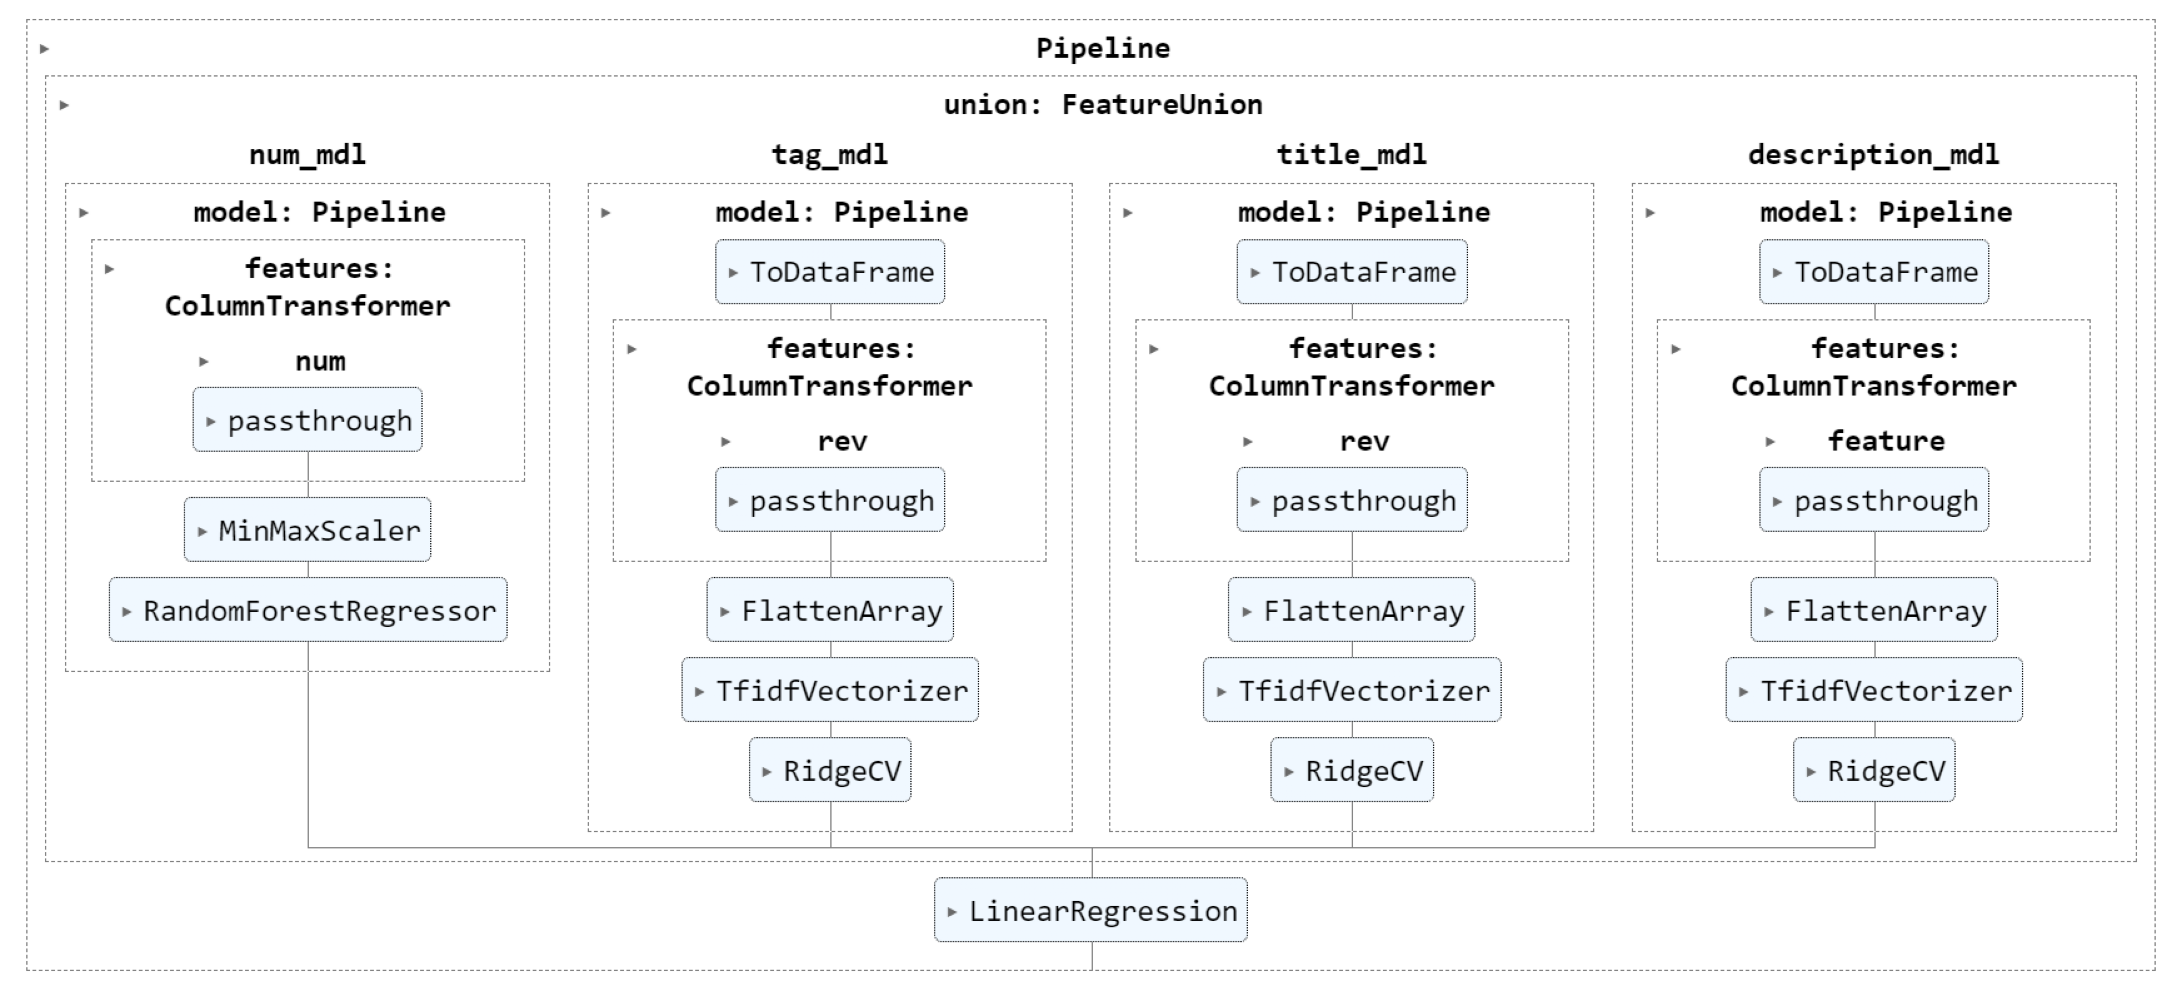

In [11]:
# # =====================================================================
# # Model architecture
# # =====================================================================
# full_mdl.fit(X_train, y_train)
display_image_in_actual_size("Fig/pipeline.png")

### 3. Data Processing Functions

In [10]:
# =====================================================================
# YouTube API Decoding
# =====================================================================

# Print ERROR message
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

# Generate or load existing pw key
pw_key_path = 'API_Key/pw-key.pkd'

if os.path.isfile(pw_key_path):
    # Load pw key
    with open(pw_key_path, 'rb') as f:
        pw_key = dill.load(f)
else:
    # Create new pw key
    pw_key = Fernet.generate_key()

    # Save new pw key
    with open(pw_key_path, 'wb') as f:
        dill.dump(pw_key, f)

fernet = Fernet(pw_key)

# Decode and obtain API key
enc_api_key_path = 'API_Key/enc-api-key.pkd'

if os.path.isfile(enc_api_key_path):
    # Load enc api key
    with open(enc_api_key_path, 'rb') as f:
        enc_api_key = dill.load(f)
else:
    eprint("Encrypted API Key cannot be found!")

#     # Save enc api key
#     with open(enc_api_key_path, 'wb') as f:
#         dill.dump(enc_api_key, f)

# Get API key
api_key = fernet.decrypt(enc_api_key.encode()).decode()

# =====================================================================
# Function to convert a raw tags to a string of words
# The input is a single string (a raw video tags), and
# the output is a single string (a preprocessed video tags)
# =====================================================================
def tags_to_words(raw_tags):
    words = raw_tags.lower().split('|') 
    # In Python, searching a set is much faster than searching a list,
    # so convert the stop words to a set to improve execution time this conversion should be done once
    stops = set(stopwords.words("english"))

    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]

    # Join the words back into one string separated by space, and return the result.
    return (",".join(meaningful_words))


# =============================================================
# Function to convert a raw tags to a string of words
# The input is a single string (a raw video tags), and
# the output is a single string (a preprocessed video tags)
# =============================================================
def sentence_to_words(raw_sentence):
    words = raw_sentence.lower().split(' ')
    stops = set(stopwords.words("english"))    
    meaningful_words = [w for w in words if not w in stops]
    return (",".join(meaningful_words))

# =====================================================================
# Function to fetch YouTube channel data based on channel ID
# =====================================================================
def get_youtube_channel_data_with_id(channel_id):    
    channel_data = {
        'channel_id':[],
        'channel_views':[],
        'channel_subscriber_count':[],
        'channel_video_count':[]
    }

    channel_request_url = f"https://www.googleapis.com/youtube/v3/channels?id={channel_id}&key={api_key}&part=statistics,contentDetails,topicDetails,snippet,brandingSettings,status"

    channel_request = requests.get(channel_request_url, verify=False)

    if channel_request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()

    channel_items = channel_request.json().get('items', [])

    if len(channel_items) > 0:
        channel_views = float(channel_items[0]['statistics']['viewCount'])
        channel_subscriber_count = float(channel_items[0]['statistics']['subscriberCount'])
        channel_video_count = float(channel_items[0]['statistics']['videoCount'])
        return (channel_views, channel_subscriber_count, channel_video_count)
    else:
        eprint("YouTube channel ID cannot be found!")
        return (0.0, 0.0, 0.0)

# =====================================================================
# Function to take user inputs and prepare model input data
# =====================================================================
def prepare_model_input_features(video_len_in_sec, title, description, tags, channel_id):
    cleaned_tags = tags_to_words(tags)
    cleaned_title = sentence_to_words(title)
    cleaned_description = sentence_to_words(description)
    tag_cnt = len(tags.split('|'))
    title_len = len(title.split(' '))
    desc_len = len(description.split(' '))

    (channel_views, channel_subscriber_count, channel_video_count) = get_youtube_channel_data_with_id(channel_id)

    prep_df = {
        'channel_id':[channel_id],
        'cleaned_tags':[cleaned_tags],
        'cleaned_title':[cleaned_title],
        'cleaned_description':[cleaned_description],
        'video_len_in_sec':[video_len_in_sec],
        'tag_cnt':[tag_cnt],
        'title_len':[title_len],
        'desc_len':[desc_len],
        'channel_subscriber_count':[channel_subscriber_count],
        'channel_video_count':[channel_video_count],
        'channel_views':[channel_views]
    }
    return pd.DataFrame(prep_df)

def postprocessing(x):
    if x > 0:
        return str(x)
    else:
        return "<100"

# =====================================================================
# Function to load presaved images
# =====================================================================
def display_image_in_actual_size(image_path):
    dpi = 80
    im_data = plt.imread(image_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

# 4. User Inputs and Model Predictions

Here is showcasing how users can type in require inputs, and the model will perform live inference and return the predicted result back to the users.

#### Please run the code below and type in the following inputs:

 1. Video length in seconds
 2. Video title
 3. Video description
 4. Video tags
 5. Video channel ID

The program will output a predicted number of views of your upcoming video.

In [38]:
# =====================================================================
# Take user inputs
# =====================================================================
input_video_length = float(input("Please enter your video length (in seconds): "))
input_video_title = input("Please enter your video title: ")
input_video_description = input("Please enter your video description: ")
input_video_tags = input("Please enter your video tags (if more than 1 tag, please use comma or | to separate): ")
input_channel_id = input("Please enter your YouTube channel ID: ")

input_df = prepare_model_input_features(input_video_length,
                                        input_video_title,
                                        input_video_description,
                                        input_video_tags,
                                        input_channel_id)

# =====================================================================
# Print prediction output
# =====================================================================
output = full_mdl.predict(input_df)

print("\n\n\x1b[1;31m" + "Your predicted video views on YouTube is: \x1b[0m" + postprocessing(int(output[0])))

# Sample Channel IDs
# UCRe9X-NCu7fUZw_GRpalCPg
# UChNN7VBxPTiNrqjUaQd9bxA
# UCI2HP_vXCbdWAeY_VCMgDSg
# UCWJqDItSEj4ljcd_gMuSCOA

Please enter your video length (in seconds): 360
Please enter your video title: Fitness Dance Tutorial - Day 1
Please enter your video description: This video showcases the very first Dance tutorial for everyone.
Please enter your video tags (if more than 1 tag, please use comma or | to separate): Fitness|Workout|Dance
Please enter your YouTube channel ID: UCRe9X-NCu7fUZw_GRpalCPg


Your predicted video views on YouTube is: 17807


### 5. Visual Data Analysis

#### 5.1 Popular Tags

* This is to showcase the popularity of tags for Fitness YouTube videos.

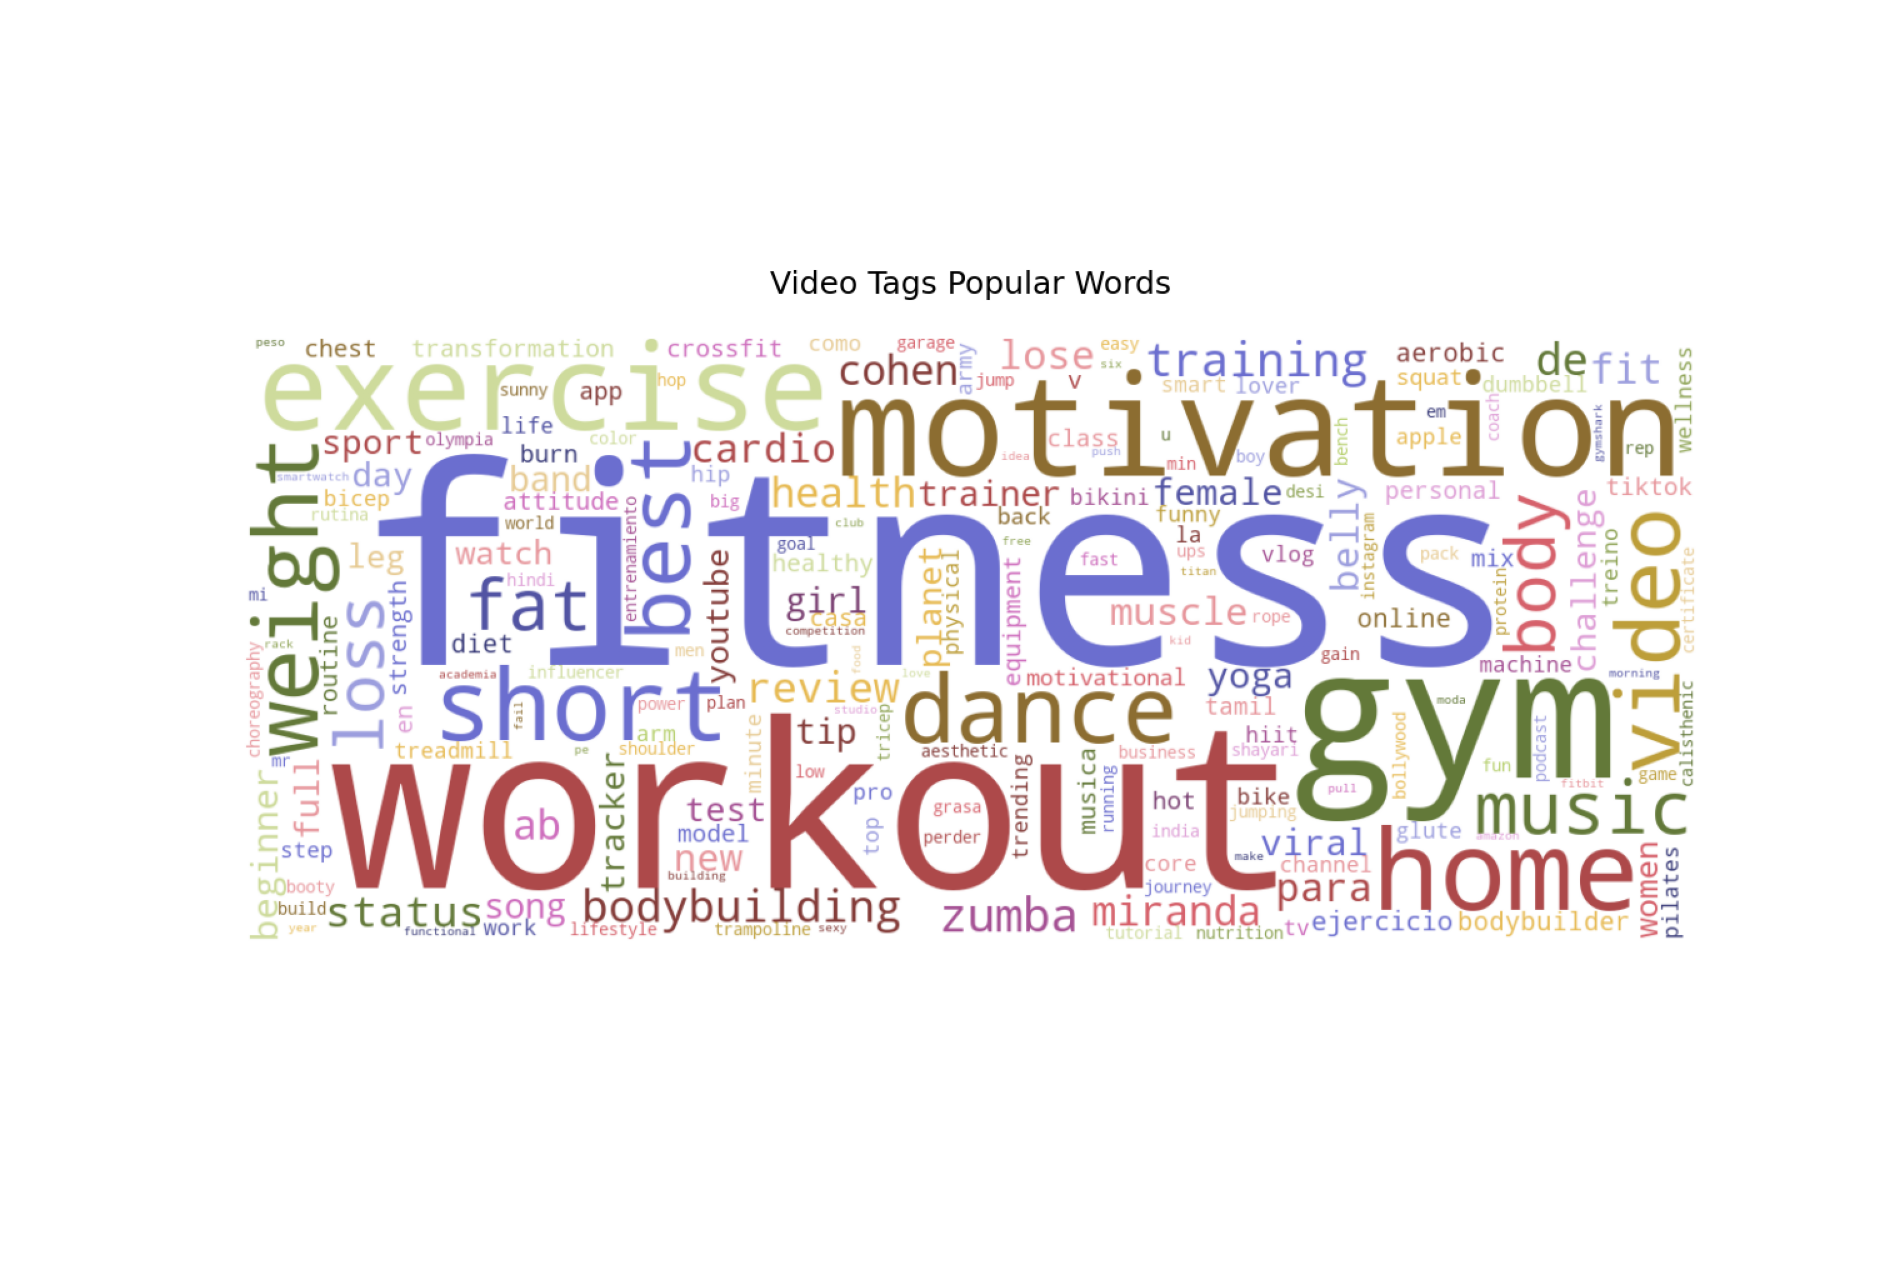

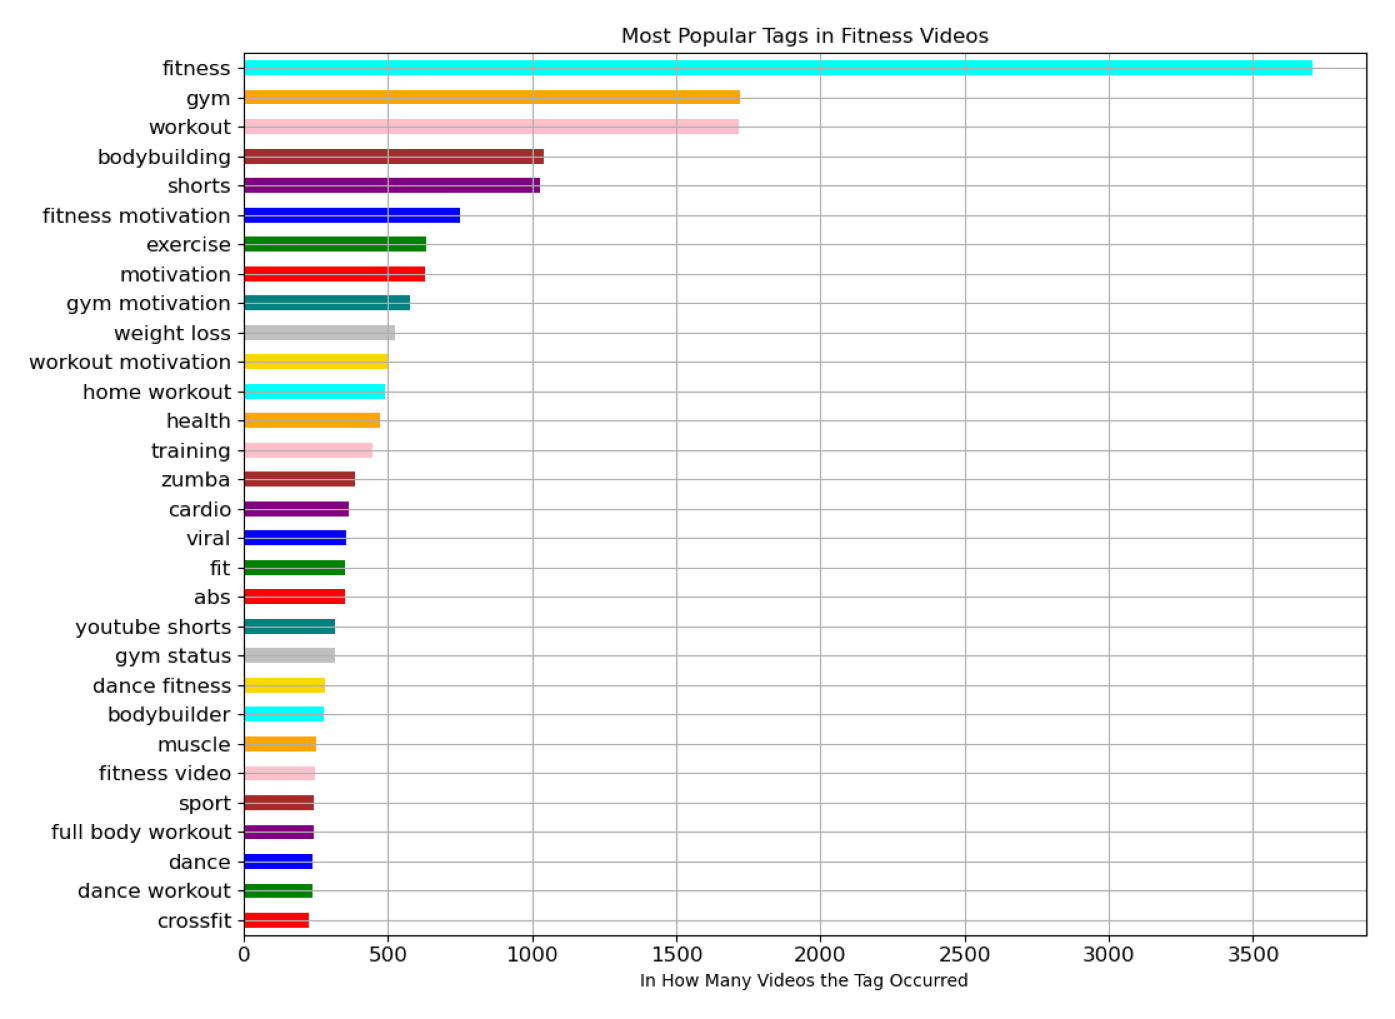

In [8]:
display_image_in_actual_size("Fig/ViewsCloud.png")
display_image_in_actual_size("Fig/ViewsPopular.png")

#### 5.2 Feature Size and Correlation

* This is to showcase the sizes and ranges of the input features, as well as the correlation between themselves.

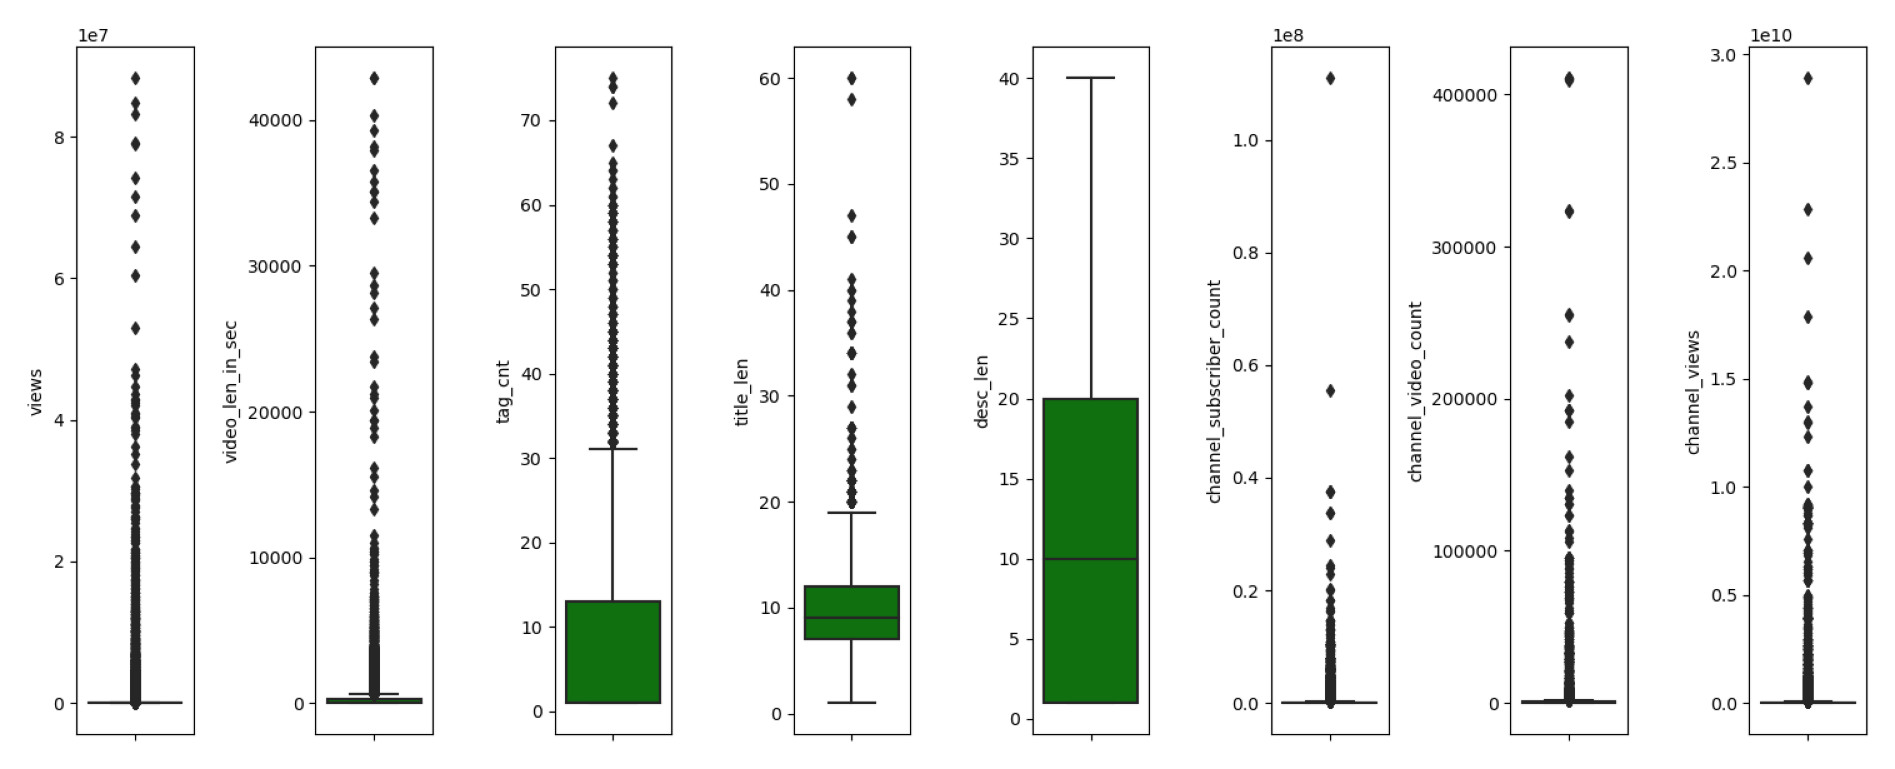

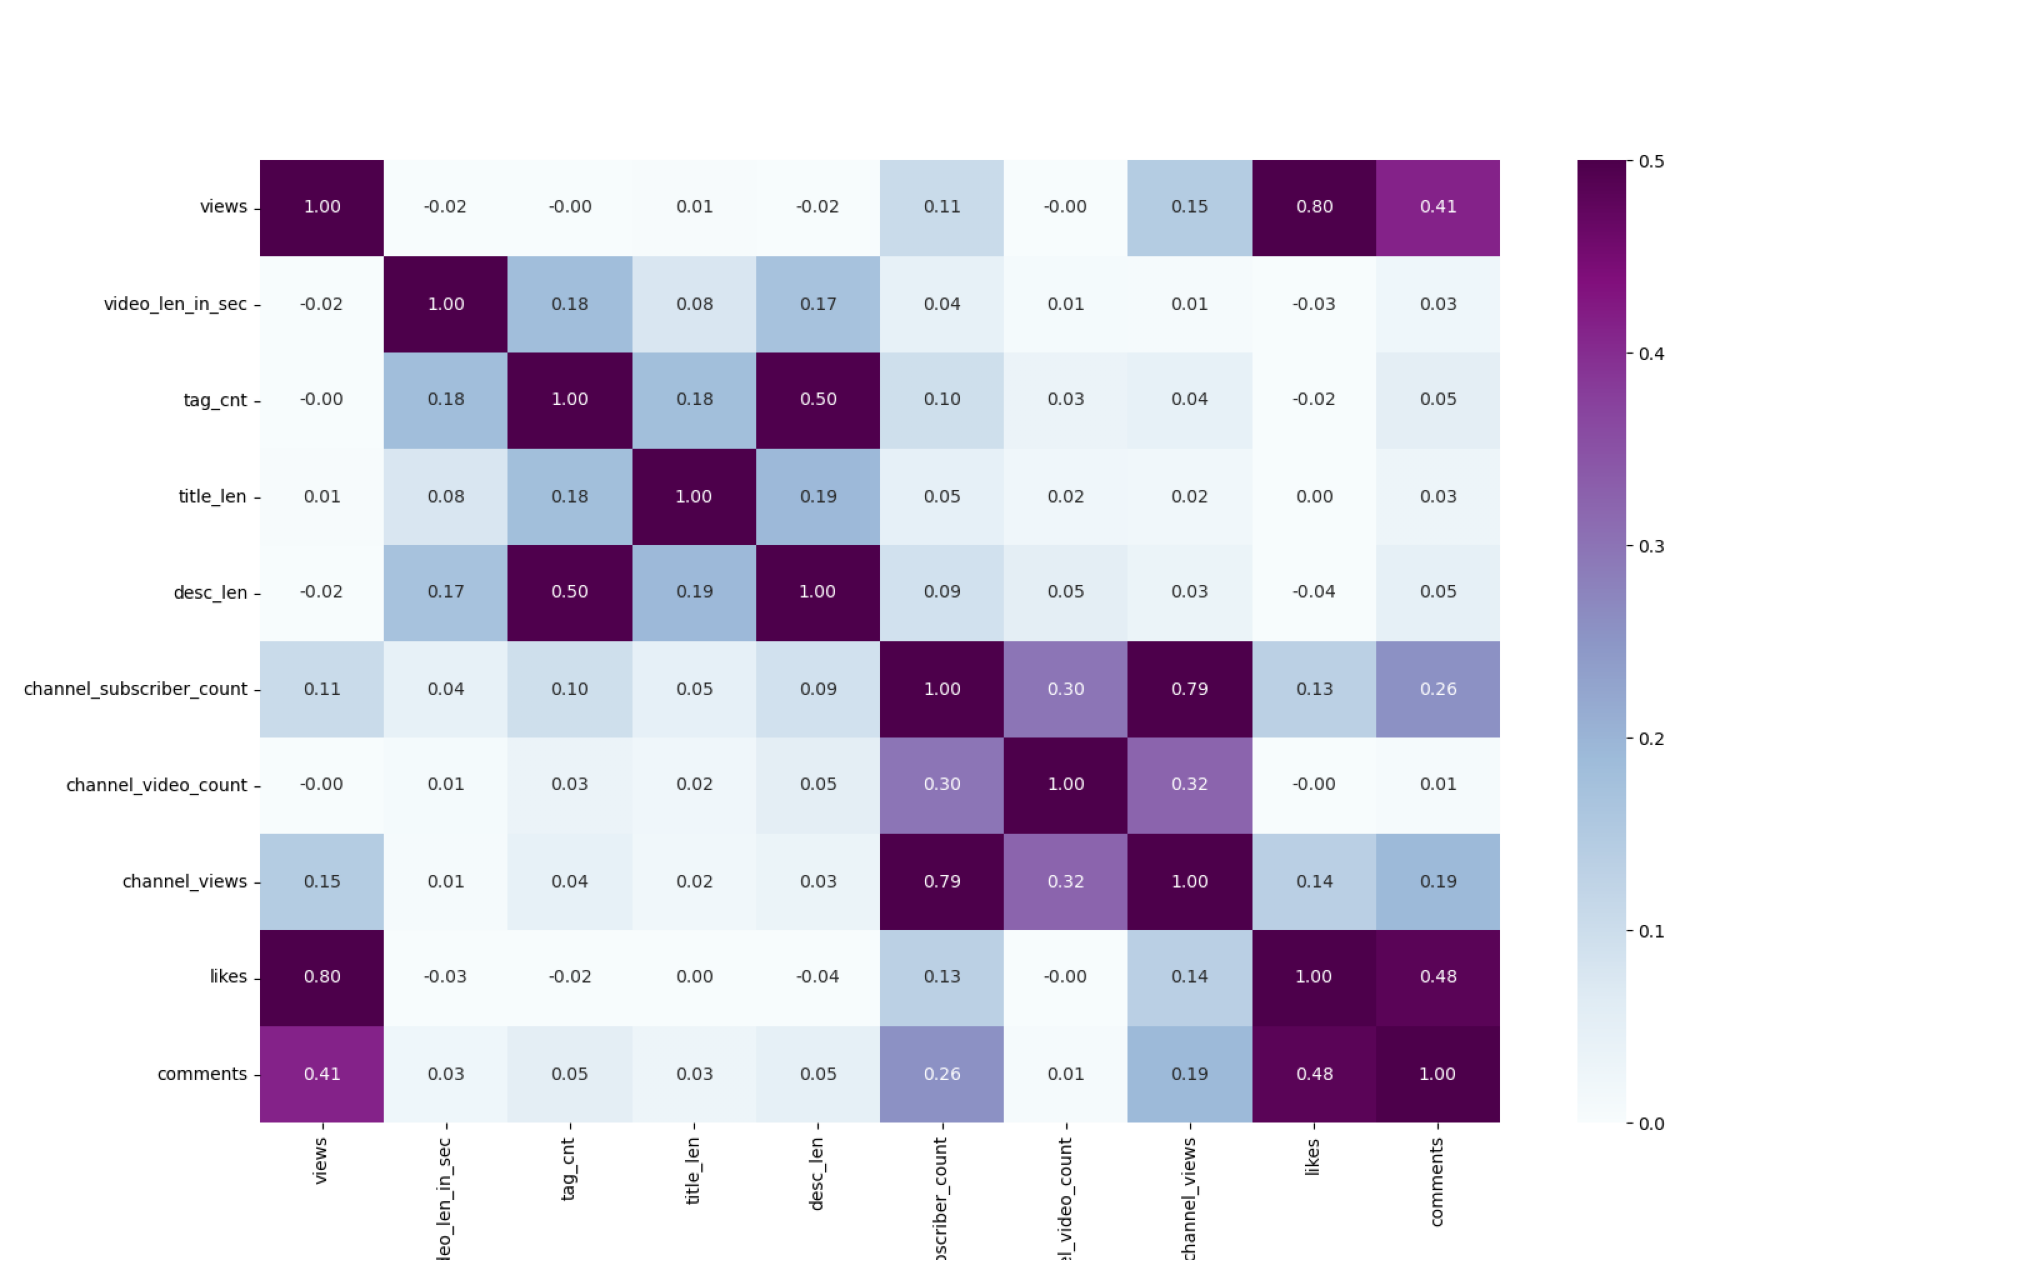

In [37]:
display_image_in_actual_size("Fig/boxplot.png")
display_image_in_actual_size("Fig/heatmap.png")

#### 5.3 Feature Correlation with Target

* This is to showcase the correlation between the input features and the target output.

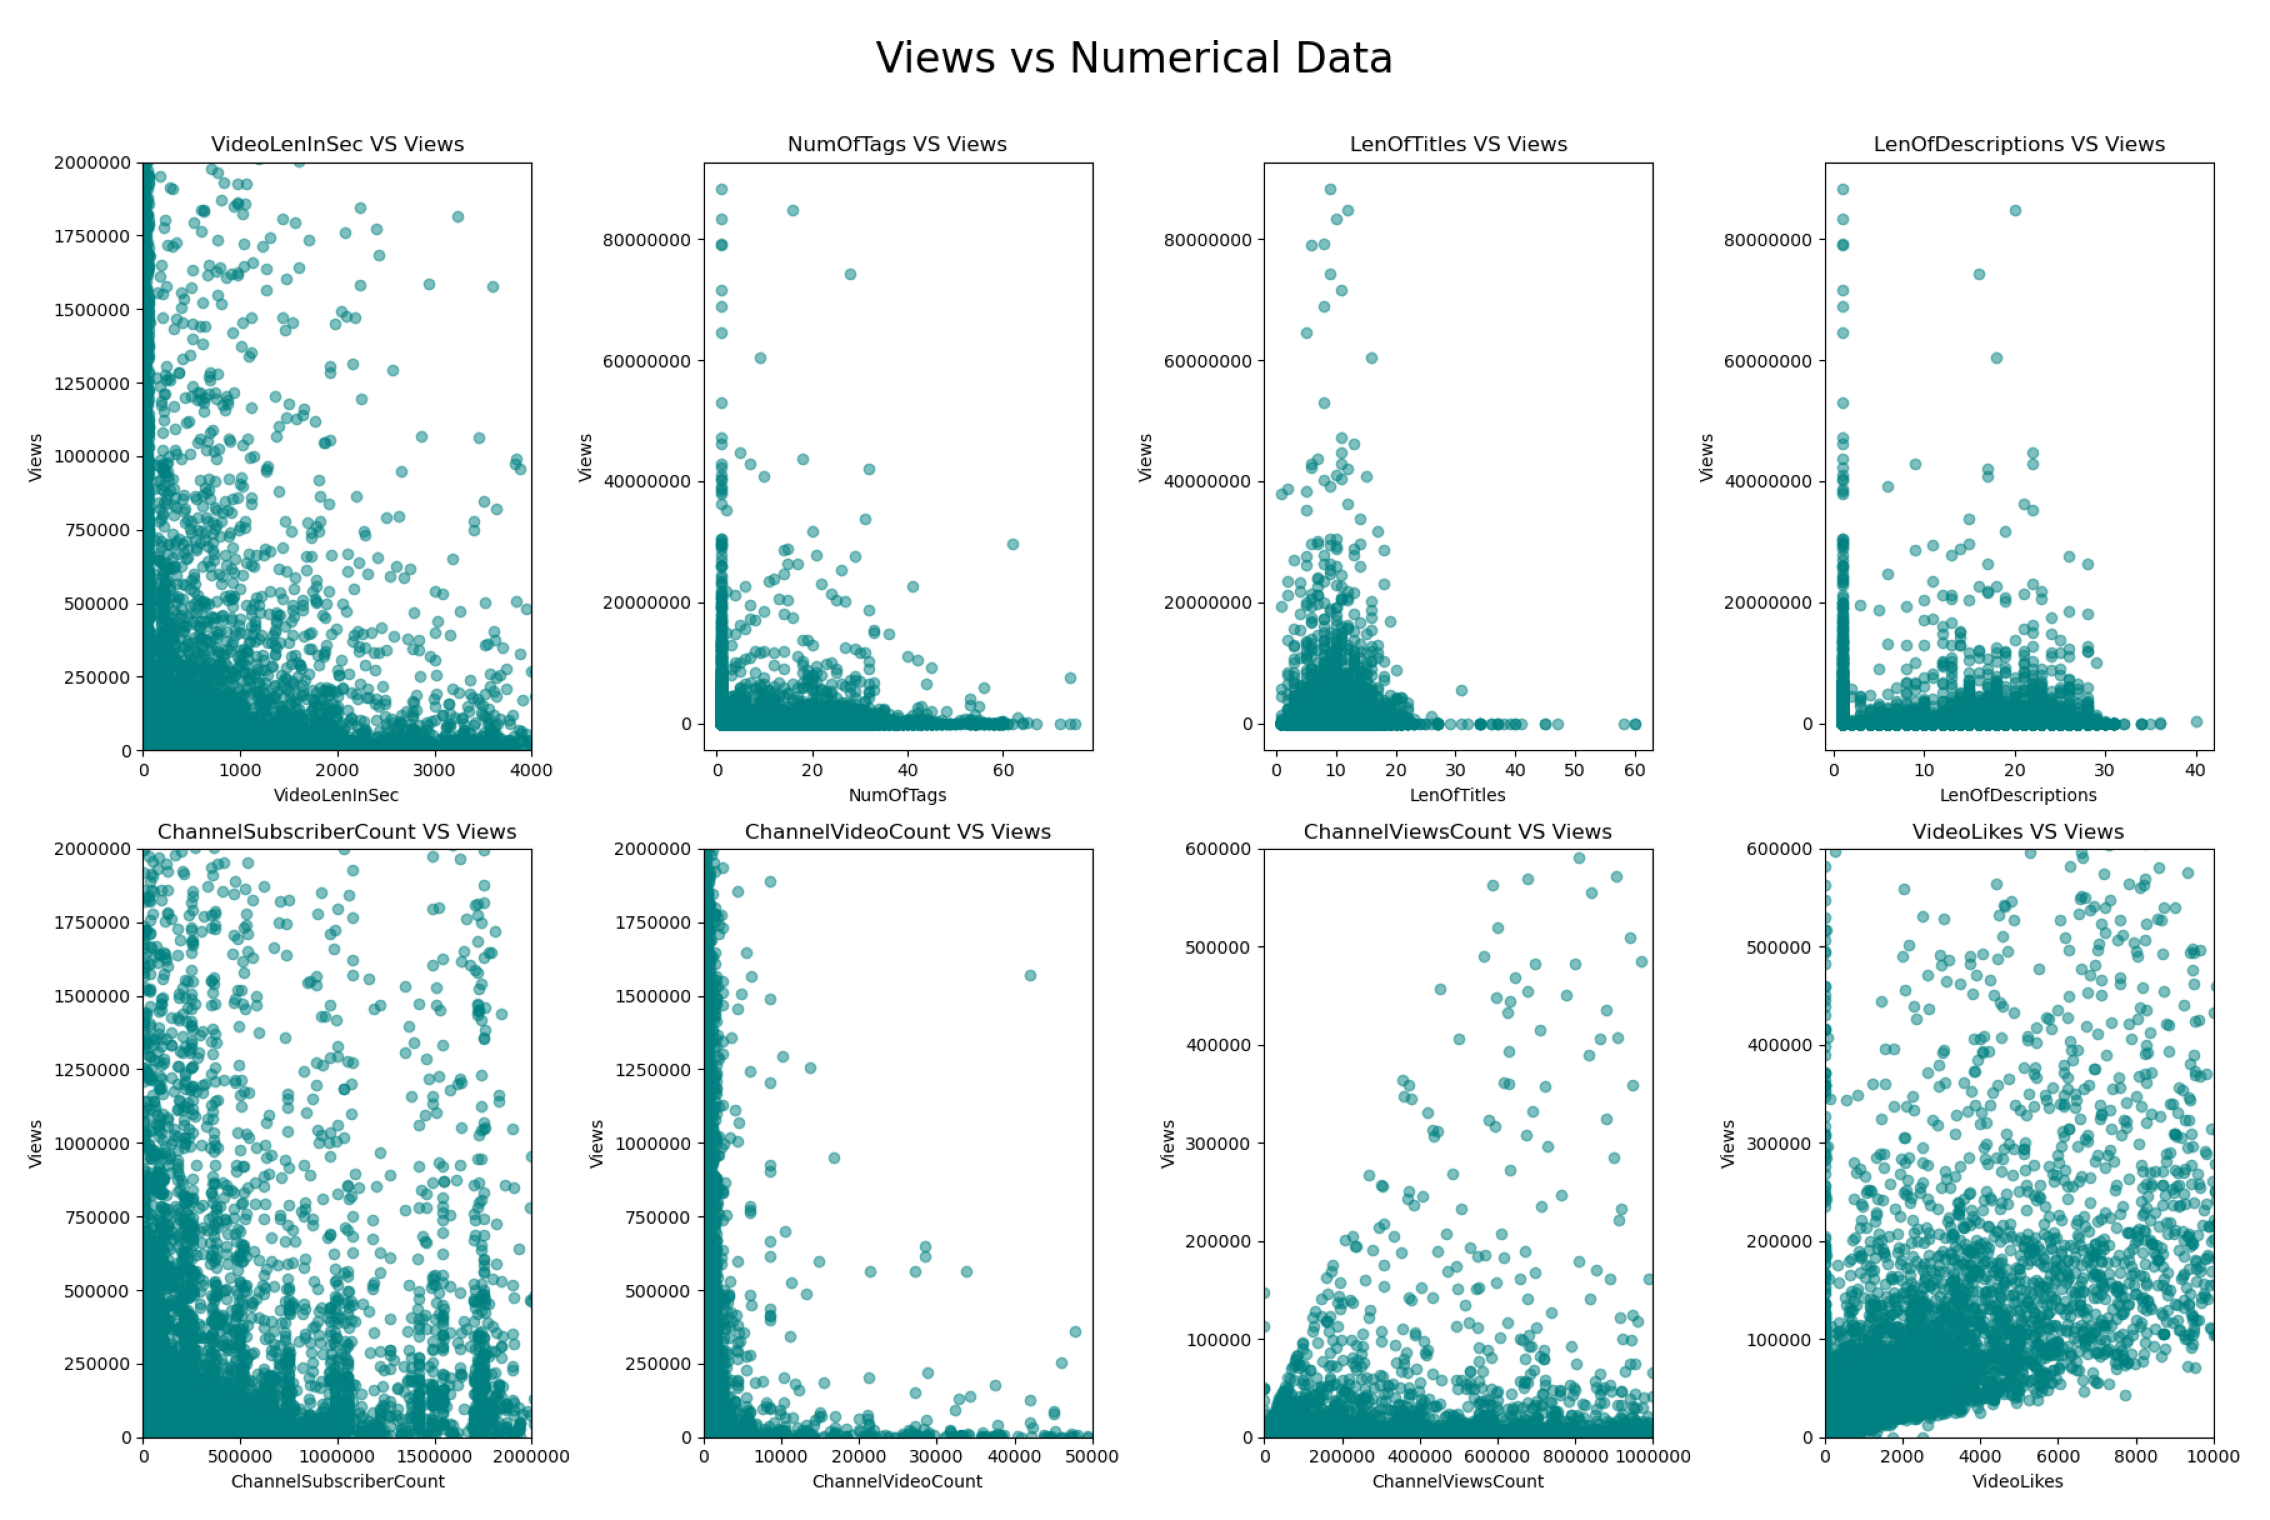

In [29]:
# display_image_in_actual_size("Fig/pairplot7.png")
display_image_in_actual_size("Fig/ViewsPlot7.png")

### 6. Summary

The objective of this project is to showcase developing a machine learning model with the utilization of YouTube video attributes to predict the number of views for a specific category, in this case, fitness.

I first collected a ~25K dataset of Fitness-related videos on YouTube in the US region from 2020 to 2023 via the YouTube Data API v3. A small challenge encountered here was that YouTube has a daily limit of API usage, so I could only fetch a small amount of data each day to accumulate the ~20K dataset. </br> 
After the data collection, I then performed feature engineering to extract relevant information from available features, as well as exploratory data analysis to understand the patterns and relationships between the refined input features and the number of views. </br> 
After preprocessing the data, I split it into training and testing sets and use the selected features (video title, description, tags, length, channel views, subscribers count, videos count) to train several machine learning models, including a numerical model utilizing logistic regression, bag-of-words text model, TF-IDF text model, and models that are pipelined and incorporate both numerical and text models. I evaluated these models and selected the best performing one based on its prediction accuracy. </br>
After that, I built a simple user interface to take user inputs (video title, description, tags, length, and channel ID), hook up with backend function to perform data preprocessing and get related features, perform model inference using the best model, and output the predicted result back to the user. </br>

The impact of developing this YouTube views prediction model is to help content creators to estimate their videos popularity by selecting different video titles, descriptions, tags, and length combinations. By knowing the factors that influence the number of views a video receives, creators can optimize their videos for better visibility and engagement.

### 7. Future Improvement

The future extensions of this project are discussed in several areas.
1. Building a web UI can enable users to interact with the model more efficiently and easily, leading to more accurate and customized predictions based on user preferences and inputs.
2. More training and evaluation data should be collected over the past decade to improve the accuracy of the next model training and evaluation iterations. A minimum of 1M training data is recommended to produce a reasonably accurate views prediction model.
3. The same model architecture and feature engineering techniques used in this project can be applied to other categories, such as cooking, travel, or music, to develop category-specific models that provide insights into the factors that influence the popularity of videos in different categories.
4. As the model training dataset continues to expand, distributed computation workflows and storage are required for efficient data processing and storage.


### Appendix - Detailed Future Extensions

#### A.1 More Training and Evalation Data

The current dataset consists of approximately ~20K samples collected over the past three years. As part of future extensions, collecting data spanning the past decade would be beneficial to improve the next model training and evaluation iterations. In order to produce a reasonably accurate views prediction model, a minimum of 1M training data is likely required and preferred.

#### A.2 Distributed Computation Workflows and Storage

As the model training dataset continues to expand, the required complexity of preprocessing and feature engineering will become more challenging. Furthermore, both data storage and processing will require additional enhancements to function efficiently. One promising approach is to migrate to a cloud-based platform such as Google Cloud. Doing so would offer numerous possibilities and enable the creation of a more systematic approach to data preprocessing and storage. For example, Google Flume jobs could be established to perform distributed data processing, and Google Spanner could serve as the central storage for raw data input and labels, as well as all preprocessed data and features such as MUSE embeddings, TD-IDF data, and EfficientNet image embeddings, among others.


References:

Google Flume: https://cloud.google.com/blog/products/data-analytics/how-cloud-batch-and-stream-data-processing-works

Google Spanner: https://cloud.google.com/blog/topics/developers-practitioners/what-cloud-spanner

#### A.3 DNN Model Architecturing

During the current exercise, we have explored several iterations of models. As we move forward, we can utilize the deep neural network (DNN) model infrastructure of TensorFlow to build models that can achieve high accuracy and performance. TensorFlow's DNN architecture allows for more complex and deeper models to be developed, enabling us to extract more intricate patterns and insights from the data. Furthermore, TensorFlow's flexible and scalable nature enables us to easily deploy these models on a variety of platforms, making it a valuable tool for building robust and efficient machine learning systems. By utilizing TensorFlow models, we can take advantage of other advanced techniques such as convolutional neural networks and recurrent neural networks, which can improve the model accuracy and robustness in various situations.

#### A.4 Distributed Model Training

The project faces a challenge of slow model training process and time. To address this challenge, one of the viable options is to utilize distributed model training. By leveraging distributed model training, it is possible to improve the speed and time of model training, and also perform multiple model training processes concurrently. This approach can significantly reduce the time and effort required for model training, and enable faster iteration and experimentation with different models and parameters. Moreover, distributed model training with TensorFlow can also provide automatic scaling and fault tolerance, allowing for efficient and robust utilization of computational resources.

More information can be found here: https://www.tensorflow.org/guide/distributed_training.

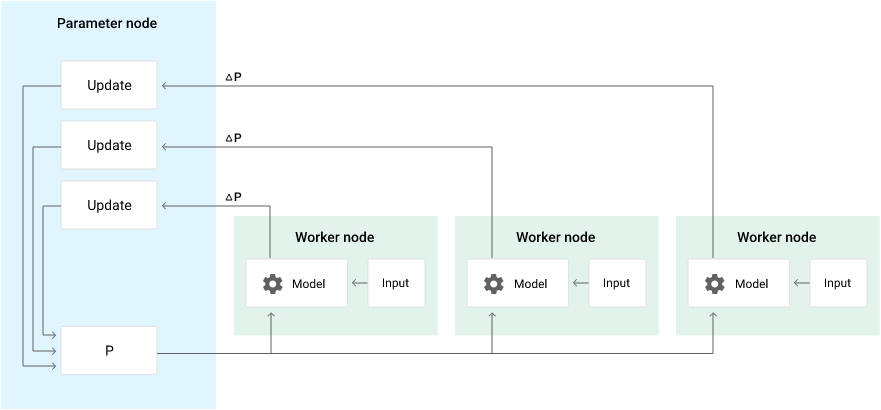

#### A.5 New Text and Image Features

There are potential benefits to utilizing existing feature embeddings to improve the quality of the model. Specifically, for text-based features such as video titles, descriptions, and tags, MUSE and BERT embeddings can be leveraged to potentially enhance the performance of the model. Similarly, for image-based features such as thumbnail images, the use of EfficientNet, ResNet, and other available embeddings can also contribute to improving the overall quality of the model.

All of the aforementioned model embeddings are readily accessible through TensorFlow Hub (https://tfhub.dev/). This provides a major advantage, as it eliminates the need to develop and train the embeddings from scratch, which can be a time-consuming and computationally intensive process. By utilizing pre-trained embeddings, we can significantly reduce the time required for model development and training. Additionally, pre-trained embeddings are often trained on large and diverse datasets, allowing us to benefit from their generalizability and performance on a wide range of tasks. Overall, utilizing pre-trained embeddings from TFHub can help us improve the accuracy and efficiency of our models.

#### A.6 Interactive Web UI

Due to limitations in time and resources, this project does not include an interactive website for real-time user/model interactions. However, in the future, building a web UI can enable users to interact with the model more efficiently and easily. This can lead to more accurate and customized predictions based on user preferences and inputs. Additionally, a web UI can allow for the collection of feedback from users, leading to continuous improvement and development of the model.

There are several web UI technologies and frameworks that can be leveraged to provide Tensorflow model prediction to users after they input the required model inputs. Some popular options include Flask, Django, and Streamlit.

Flask is a lightweight and flexible web framework for Python that is widely used in developing web applications. It allows easy integration with Tensorflow models through Python code.

Django is a high-level web framework that provides a full-stack framework for web development. It also allows integration with Tensorflow models through Python code.

Streamlit is a newer framework specifically designed for data science and machine learning applications. It allows for rapid prototyping and easy integration with Tensorflow models through Python code.

All of these frameworks can be used to create a web UI that accepts user inputs and returns predictions from a Tensorflow model. The specific choice will depend on the project requirements, available resources, and personal preference.

#### A.7 Generalization to All Categories

The model used in this project is trained using data from Fitness YouTube videos. However, this model has the potential to be extended to other categories beyond Fitness. With appropriate data collection and preprocessing, the same model architecture and feature engineering techniques can be applied to other categories, such as cooking, travel, or music, to develop category-specific models. These models can potentially provide insights into the factors that influence the popularity of videos in different categories and help content creators tailor their videos to meet the preferences of their target audience.

### Appendix - Model Verification and Testing

In [9]:
pred_num = num_mdl.predict(X_test)
pred_num = [round(x, 1) for x in pred_num]

pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_num})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,2407110.8
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,56832.6
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,1080737.8
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,1721.9
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,1141.6
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,726692.0
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,1155.4
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,516208.2
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,1092360.1


In [10]:
pred_cat = cat_mdl.predict(X_test)
pred_cat = [round(x, 1) for x in pred_cat]

pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_cat})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,151691.5
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,-765098.1
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,52592.8
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,201792.1
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,-300800.6
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,170335.2
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,-197520.8
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,165121.5
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,1116415.9


In [55]:
pred_full = full_mdl.predict(X_test)
pred_full = [round(x, 1) for x in pred_full]

pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_full})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,3086880.6
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,49601.1
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,1373368.9
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,-92786.5
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,-1680.6
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,878821.0
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,-20542.9
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,679651.7
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,1304681.3


In [56]:
test_feature = X_test[1000:1020]
test_target = y_test[1000:1020]

pred_full_test = full_mdl.predict(test_feature)
pred_full_test = [round(x, 1) for x in pred_full_test]

pd.DataFrame( data={"channel_id":test_feature["channel_id"], "views":test_target, "views_preds":pred_full_test})

,channel_id,views,views_preds
12826,UC6EGIlM6JTiIGUUF7AdnP6w,4489.0,7918.5
8341,UCtPucLB-YNz-SrUTwbxe7Vw,219.0,-48017.1
12679,UCLUViqGDyNch93nUqzJaWYA,1265.0,-364007.5
15863,UCKfDrxypayMm6TotOMckpWQ,813219.0,422384.8
14805,UCafrZwyn8oZuuc-TAE4gbpw,534.0,-202884.2
22328,UCtPhjzXZgw8EImCCeMa5Diw,31981.0,411462.8
17248,UCu0l8LEELZa2XqAjvMNZamg,201309.0,188362.6
12381,UCYMx47MEAtKRDhvacRALWQA,496.0,-35196.0
20262,UC24j-kXAJ3JMJUEgxufWpbw,2786.0,-74457.3
1475,UCJUWgf6KhnmLtbZe2S0josw,4652.0,-276451.4


In [57]:
pred_description = description_mdl.predict(X_test)
pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_description})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,254856.185548
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,332332.054610
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,417155.262440
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,417155.262440
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,417155.262440
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,312207.909156
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,417155.262440
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,924400.785836
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,345980.198009


In [58]:
pred_decrp_test = description_mdl.predict(X_test)
pred_decrp_test = [round(x, 1) for x in pred_decrp_test]
pd.DataFrame( data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_decrp_test})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,254856.2
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,332332.1
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,417155.3
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,417155.3
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,417155.3
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,312207.9
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,417155.3
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,924400.8
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,345980.2


In [59]:
pred_title = title_mdl.predict(X_test)
pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_title})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,303744.062688
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,-14902.358216
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,145341.929835
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,231666.526902
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,-59126.481172
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,210935.598929
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,629.719962
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,1302.618952
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,433159.034271


In [60]:
pred_tag = tag_mdl.predict(X_test)
pd.DataFrame(data={"channel_id":X_test["channel_id"], "views":y_test, "views_preds":pred_tag})

,channel_id,views,views_preds
2350,UC6gJAnIhDn2Fy_jZfICmgSA,442530.0,413724.382737
23251,UCBINFWq52ShSgUFEoynfSwg,32499.0,34924.838965
11000,UCUjxVpMBQpzjvz0yJRFd88g,122132.0,406155.474460
13627,UC1NWIZREkKB6sq6kLzylJZA,23.0,406155.474460
21896,UCkrmXhwzOwAzBIUwg6q_G7g,695.0,406155.474460
...,...,...,...
2026,UCmY7I4FySqewJsf5Z80j93A,18677.0,508990.142403
18673,UC24j-kXAJ3JMJUEgxufWpbw,5274.0,406155.474460
10941,UCqBnL2xgLovmB2oZTnho7DQ,599447.0,228524.913920
14088,UCs-2c06VmHqGB5mGmz5vE_A,4559178.0,946222.297253


In [61]:
pred_tag_test = tag_mdl.predict(test_feature)
pred_tag_test = [round(x, 1) for x in pred_tag_test]

pd.DataFrame( data={"channel_id":test_feature["channel_id"], "views":test_target, "views_preds":pred_tag_test})

,channel_id,views,views_preds
12826,UC6EGIlM6JTiIGUUF7AdnP6w,4489.0,406155.5
8341,UCtPucLB-YNz-SrUTwbxe7Vw,219.0,406155.5
12679,UCLUViqGDyNch93nUqzJaWYA,1265.0,-33180.3
15863,UCKfDrxypayMm6TotOMckpWQ,813219.0,406155.5
14805,UCafrZwyn8oZuuc-TAE4gbpw,534.0,1789132.6
22328,UCtPhjzXZgw8EImCCeMa5Diw,31981.0,300377.9
17248,UCu0l8LEELZa2XqAjvMNZamg,201309.0,258535.5
12381,UCYMx47MEAtKRDhvacRALWQA,496.0,229163.4
20262,UC24j-kXAJ3JMJUEgxufWpbw,2786.0,406155.5
1475,UCJUWgf6KhnmLtbZe2S0josw,4652.0,406155.5
